
TODO:
- Referenze classi  [github](https://github.com/fredffsixty/Natural_Language_Processing/blob/main/Esercitazioni/E6.%20BERT/Esercitazione6b.ipynb)
- Fare confronto tra dataset originale e aumentato
- Adattarlo anche al secondo dataset
- Rifare introduzione, togliere estremismi
- Controllare funzione di attivazione (binaria vs multi class)
- Verificare che la predizioni funzioni o se bisogna aggiungere funzione attivazione anche li
- [Controllare per classificazione binaria](https://machinelearningmastery.com/building-a-binary-classification-model-in-pytorch/)
- [Controllare per classificazione multi classe](https://machinelearningmastery.com/building-a-multiclass-classification-model-in-pytorch/)



Per la submission:

Dopo aver fatto l'architettura fare un giro di addestramento con tutto il dataset per rendere più resistente la rete, poi fare le predizioni


Task

Subtask A: Conspiratorial Content Classification: A system must recognize if a telegram
post is conspiratorial or not.

A sentence is Conspiratorial if either  
(i) expresses the belief that major events(e.g., covid) are manipulation created by powerful people to protect their interests  
 or  
(ii) an interpretation of events meant to contribute to strengthening the underlying narrative of the conspiracy theory.

A sentence is Not Conspiratorial if it does not diffuse any kind of beliefs linked to the conspiracy theory.

Definizione della teoria del complotto

Una teoria del complotto o della cospirazione (talvolta nella forma aggettivale: teoria complottista o cospirativa) è una teoria o spiegazione di un evento o una situazione, spesso alimentata da motivazioni politiche, che ne attribuisce cause e responsabilità a una cospirazione ordita da gruppi elitari e potenti (spesso detti «poteri forti»), nonostante le altre spiegazioni già fornite siano più plausibili e affidabili. Il termine ha una connotazione negativa, poiché implica che il credere a tali teorie sia una pratica basata sul mero pregiudizio e su prove insufficienti. Una «teoria del complotto» non è la stessa cosa di una cospirazione; perché si riferisce a una cospirazione ipotizzata con caratteristiche specifiche, come un'opposizione al consenso tradizionale (talvolta detto «mainstream») tra quelle persone, come scienziati o storici, che sono qualificate per valutarne l'accuratezza.

Le teorie del complotto sono restie alle critiche e al principio di falsificabilità; al contrario trovano forza nella logica circolare: sia le prove che confutano il complotto che l'assenza di prove a favore della sua esistenza sono reinterpretate dai complottisti come indiscutibili dimostrazioni della sua verità, per cui la cospirazione diventa una questione di fede piuttosto che qualcosa che può essere provato o confutato. La ricerca suggerisce che l'ideologia complottista—la fede nelle teorie del complotto—può essere psicologicamente dannosa o patologica e che è correlata a scarso pensiero analitico, basso quoziente d'intelligenza, proiezione psicologica, paranoia e machiavellismo. Gli psicologi attribuiscono il trovare teorie del complotto lì dove non ce ne sono a un fenomeno mentale chiamato «apofenia».

[Fonte](https://it.wikipedia.org/wiki/Teoria_del_complotto)

In [1]:
#!pip install scikit-learn pandas numpy nltk transformers torch matplotlib seaborn python-dotenv emoji 

Documentazioni:  
Hugchat: https://pypi.org/project/hugchat/


Il dataset presenta una lista di messaggi/post raccolti su vari social, una delle caratteristiche di queste forme di comunicazioni sono le emoticon (o emoji) e la forma del messaggio in se.
Questo significa che un testo che vuole catturare l'attenzione avrà un "titolo" d'impatto e spesso in maiuscolo, in quanto l'attenzione dedicata a questo tipo di contenuti è poca e di carattere transitorio.  

Inoltre il dataset presenta una quantità di dati inadatta all'addestramento di un classficatore superabile tramite tecniche di data augmentation, questa caratteristica è intriseca nel problema in quanto i trend [^1] durano molto poco nel tempo e per un sistema di riconoscimento dei contenuti fuorvianti è necessario essere in grado di adattarsi in breve a queste variazioni.  

Il dataset ha dimensione eterogenea, il che potrebbe portare a esempi per il transformer dove sono presenti lunghe stringhe di filler.  

Di seguito verranno proposte alcune tecniche di preprocessing e di data augmentation  




[^1]: Per trend si indica un argomento che cattura l'attenzione del pubblico e che ha orizzonte temporale molto breve, di solito nell'ordine dei giorni.

Possibili tentativi  

Data augmentation
- prendere solo i caratteri ripetuti o parole maiuscole e emoticon dal testo e verificare la label, questo può funzionare in quanto spesso la comunicazione passa per l'impatto della forma  

- utilizzare altri modelli di elaborazione del linguaggio, chiedendo di modificare il testo mantenendone il significato, nascondendone parti o riformulare la frase


Data preprocessing  

- Raccolta di una percentuale della frase per raccogliere il "titolo"

In [3]:
#from google.colab import drive

#drive.mount('/content/gdrive')
#root = '/content/gdrive/MyDrive/Colab Notebooks/dataset/'

root = './Dataset/'

In [4]:
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm
import time
from torch.optim import Adam
from torch import nn
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoConfig, AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.utils import shuffle
import nltk
import matplotlib.pyplot as plt
import emoji
import copy
import pickle


In [5]:
pd.set_option('display.max_colwidth', None)
dataset = pd.read_csv(f'{root}subtaskA_train.csv',  header=0, names=['id', 'text', 'label'])
color1 = (0.2, # redness
         0.4, # greenness
         0.2, # blueness
         0.6 # transparency
         )
color2 = (0.4, 0.2, 0.2, 0.6)
color3 = (0.6, 0.3, 0.1, 0.7)
color4 = (0.1, 0.5, 0.4, 0.5)
color5 = (0.8, 0.2, 0.3, 0.8)
colors = [color1, color2, color3, color4, color5]

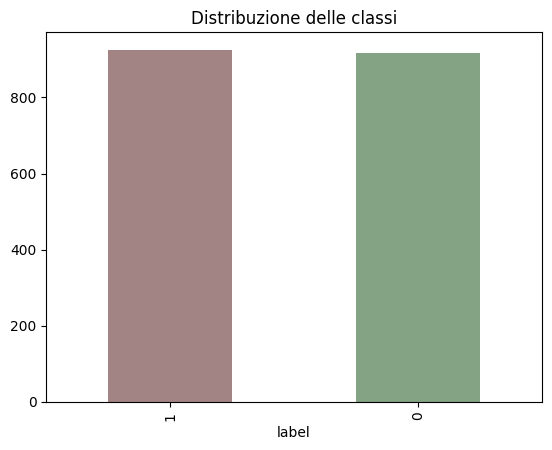

In [6]:
dataset['label'].value_counts().plot(kind='bar', color=[color2,color1])
plt.title('Distribuzione delle classi')
plt.show()


In [6]:
print("dati mancanti")
print(dataset.isna().sum())

dati mancanti
id       0
text     0
label    0
dtype: int64


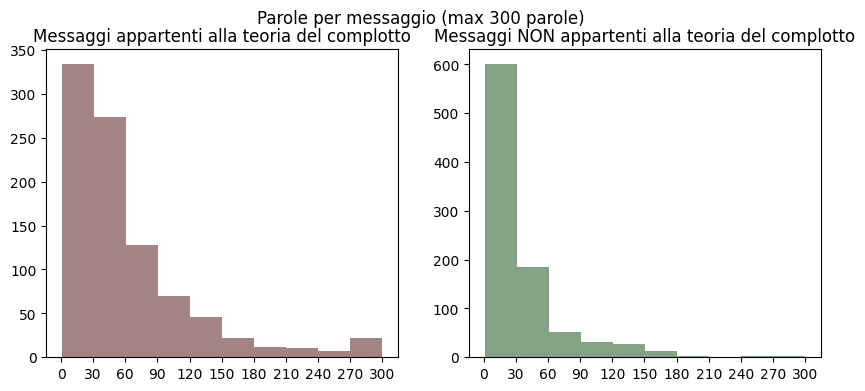

In [7]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
ax1.set_xticks([0,30,60,90,120,150,180,210,240,270,300])
ax2.set_xticks([0,30,60,90,120,150,180,210,240,270,300])
dataset_words=dataset[dataset['label']==1]['text'].str.split().map(lambda x: len(x) if len(x)<300 else 300)
ax1.hist(dataset_words,color=color2)
ax1.set_title('Messaggi appartenti alla teoria del complotto')
dataset_words=dataset[dataset['label']==0]['text'].str.split().map(lambda x: len(x) if len(x)<300 else 300)
ax2.hist(dataset_words,color=color1)
ax2.set_title('Messaggi NON appartenti alla teoria del complotto')
fig.suptitle('Parole per messaggio (max 300 parole)')
plt.show()

Dall'analisi effetuata sul dataset notiamo come sia bilanciato rispetto alle labels e non presenta mancanza di dati nei sample.

Da quest'ultimo grafico notiamo che i messaggi più lunghi di un ottantina di caratteri hanno un alta probabilità di appartenere alla teoria del complotto, questo comportamento può indicare che la lunghezza dei messaggi può essere utile alla classificazione, sarà quindi necessario verificare se la tendenza è presente anche nel dataset aumentato.

Per aumentare i dati utilizziamo delle api per il chatbot presente su [huggingface](https://huggingface.co/chat/).  

Di seguito i prompt testati e quello utilizzato per l'effettivo aumento:

<details>
<summary>Prompt test 1</summary>
<br>

    Sei un sistema per fare data augmentation per un task NLP che deve classificare se un testo è  cospirazionista o no, ti verrà fornita una coppia di valori testo-label e dovrai generare nuove righe di dati.  

    I dati generati avranno lo stesso significato di quelli inviati ma con parole diverse.   
    
    Genererai 4 righe per ogni input di cui: una con lo stesso significato e tono, una riassunta, una con lo stesso significato ed un tono più aggressivo ed  una con lo stesso significato ed un tono più amichevole.   
    
    I dati forniti sono nella forma text, label,  la label è un valore booleano che indica se il testo è cospirazionista o meno.   
    
    La label deve essere coerente con il contenuto del testo generato. La lingua del risultato deve essere italiano.
</details>

<details>
<summary>Prompt test 2</summary>
<br>

    Testo originale: Testo preso dalla cella i-esima "  

    Output desiderato:  

    "Riscrivi il testo originale utilizzando sinonimi per esprimere lo stesso significato."  
    "Fornisci un riassunto del testo originale."  
    "Sostituisci alcune parole chiave nel testo originale."  
    "Riscrivi il testo originale con un tono diverso, mantenendo però il medesimo significato ed in lingua italiana."  
    "Trasforma il testo originale in una domanda diretta."  
    
    Tutti gli output devono essere in italiano
</details>

<details>
<summary>Prompt utilizzato</summary>
<br>

    Input:
    "Testo originale: Testo preso dalla cella i-esima "

    Output desiderato:

    "Riscrivi il testo originale utilizzando sinonimi per esprimere lo stesso significato in italiano."
    "Fornisci un riassunto del testo originale in italiano."
    "Riscrivi il testo originale con un tono diverso, mantenendo però il medesimo significato in italiano."
    "Sostituisci alcune parole chiave nel testo originale in italiano."
    "Trasforma il testo originale in una domanda diretta in italiano."
    
    Richiesta di risposta (formato predefinito):
    "Inserisci qui i risultati delle trasformazioni. Usa il formato seguente senza aggiungere nulla se non il testo richiesto:

    [Sinonimi]: [Testo risultante sostituendo le parole chiave con dei sinonimi]
    [Riassunto]: [Riassunto risultante]
    [Tono diverso]: [Testo risultante con tono diverso]
    [Parole chiave sostituite]: [Testo risultante con parole chiave sostituite]
    [Domanda diretta]: [Testo risultante come domanda diretta]"

</details>  

Dai test effettuati, il miglior prompt è risultato essere quello che esplicitamente chiede la forma e imposta la formattazione del risultato, che ha permesso anche una estrazione dei dati aumentiati più veloce e semplice.  
Si è inoltre variato nelle richieste in quanto le richieste riguardo al tono non sortivano i risultati sperati, quindi si è optato per richieste più generiche e che mantenessero lo stesso significante.

La libreria utilizzata è quella di hugchat, che ci permette di interfacciarci facilmente ai chatbot messi a disposizione da huggingface e di sfruttarne le potenzialità nel codice.

In [8]:
'''
from hugchat import hugchat
from hugchat.login import Login
from dotenv import load_dotenv


load_dotenv()

email = os.getenv("EMAIL_HF")
passwd = os.getenv("PASS_HF")


# Log in to huggingface and grant authorization to huggingchat
sign = Login(email, passwd)
cookies = sign.login()

# Save cookies to the local directory
cookie_path_dir = "./cookies_snapshot"
sign.saveCookiesToDir(cookie_path_dir)
'''


'\nfrom hugchat import hugchat\nfrom hugchat.login import Login\nfrom dotenv import load_dotenv\n\n\nload_dotenv()\n\nemail = os.getenv("EMAIL_HF")\npasswd = os.getenv("PASS_HF")\n\n\n# Log in to huggingface and grant authorization to huggingchat\nsign = Login(email, passwd)\ncookies = sign.login()\n\n# Save cookies to the local directory\ncookie_path_dir = "./cookies_snapshot"\nsign.saveCookiesToDir(cookie_path_dir)\n'

I modelli disponibili sono i seguenti, è possibile cambiare cambiare modello con _chatbot.switch_llm(index)_

In [9]:
'''

cookie_path_dir = "./cookies_snapshot"
sign = Login(email, None)
cookies = sign.loadCookiesFromDir(cookie_path_dir)
chatbot = hugchat.ChatBot(cookies=cookies.get_dict())
models = chatbot.get_available_llm_models()
active_model = chatbot.switch_llm(4)
id = chatbot.new_conversation()
chatbot.change_conversation(id)
print("Modelli disponibili:")
for m in range(len(models)):
    print(models[m])

'''

'\n\ncookie_path_dir = "./cookies_snapshot"\nsign = Login(email, None)\ncookies = sign.loadCookiesFromDir(cookie_path_dir)\nchatbot = hugchat.ChatBot(cookies=cookies.get_dict())\nmodels = chatbot.get_available_llm_models()\nactive_model = chatbot.switch_llm(4)\nid = chatbot.new_conversation()\nchatbot.change_conversation(id)\nprint("Modelli disponibili:")\nfor m in range(len(models)):\n    print(models[m])\n\n'

Sono stati testati tutti i chatbot, per lo scopo del progetto sono stati utilizzati i modelli _openchat/openchat\_3.5_ e _tiiuae/falcon-180B-chat_ in quanto davano le risposte più coerenti e più vicine alla forma desiderata.

In [10]:
##Dataset di prova per testare il funzionamento dell'augmenter
df_test = dataset[:5].copy()
df_test['text'] = df_test['text'].apply(lambda x: x.replace('\r', ' ').replace('\n', ' '))
df_test.head()


,id,text,label
0,0,⚡Se non ci fossero soldati non ci sarebbero guerre.,0
1,1,"21/08/21]( [PRE-PRINT] 📄__ ""Shedding of Infectious SARS-CoV-2 Despite Vaccination"" 🇮🇹 ""Diffusione del SARS-CoV-2 nonostante la vaccinazione""__ 📊 ""La variante Delta del SARS-CoV-2 può causare elevate cariche virali, è al trasmissibile e contiene mutazioni che conferiscono una fuga immunitaria parziale. [...] le indagini sull'epidemia suggeriscono che le persone vaccinate possono diffondere [la variante] Delta"" ⚠️ ""[...] questi risultati indicano che anche le **persone asintomatiche e comple vaccinate possono diffondere il virus infettivo**."" ⚠️ ""[...] questi dati indicano che gli individui **vaccinati e non vaccinati** infettati dalla variante Delta **possono trasmettere l'infezione**."" 📚 **",1
2,2,"PAURA E DELIRIO ALLA CNN: IL MINISTERO DELLA VERITA' La scorsa settimana Elon Musk ha dichiarato di volere che la ""libertà di parola"" sui social media sia tutelata ai sensi della Legge del Paese. I DEM sono spaventatissimi dalla scelta coraggiosa del magnate dello Spazio di acquistare Twitter così scontrandosi frontalmente, e senza paura, con BlackRock, Vanguard e State Street, cioè i tre fondi di inves che controllano il 95% delle multinazionali tra le prime 500 al Mondo. I DEM americani hanno risposto con la grande sorella Hillary e il grande fratello Obama, i quali twittando hanno ordinato di allestire opportuni apparati di censura, una comanda ovviamente presa dai loro camerieri della UE e della ridicola Amministrazione Biden. Si tratta di un disperato tentativo di nascondere le Verità che stanno emergendo sul Covid19 e i vaccini, i supposti morti 'senza correlazione', le elezioni americane e francesi colossalmente truccate, i ladrocini finanziari trilionari con i derivati, i sacrifici umani e soprattutto di bambini e tante altre rivelazioni usando un ""Ministero della Verità"" in perfetto stile Orwell 1984. Questa risposta DEM è assolu incostituzionale e non basta chiamare questi abomini 'Board per la Disinformazione' (in America) o 'Piattaforma per la Disinformazione' (in Unione Europea) per giustificare il tentativo di nascondere la Verità agli occhi della gente, tentando di non sembrare quello che sempre più palesemente si è: Tiranni Globali come quelli descritti in tutta la Letteratura distopica. Ricordo che Twitter aveva censurato la Verità sul laptop di Hunter Biden poco prima delle elezioni del 2020, e se ciò non fosse stato fatto e i media avessero fatto il loro lavoro, tutti sapremmo dei traffici di esseri umani ed energetici all'ombra di BURISMA, la compagnia del gas Ucraino nel cui board sedeva il figlio di Joe Biden dopo il colpo di stato del 2014, per il fine di realizzare in Ucraina quella base della piattaforma del Male oggi usata per alimentare la possibilità di una Terza Guerra Mondiale Nucleare. Le cose stanno precipitando per i DEM con la prospettiva di ricongiungerli ai loro DEMoni ispiratori. In questo senso è al simbolica l'uscita dell'analista politico della CNN David Zurawik di ieri, quando ha detto che è molto pericolosa l'acquisizione di Twitter da parte di Elon Musk, e che l'America deve guardare all'Europa per le risposte. In preda ad un sen di paura e delirio come quello del letterato iconico dei democratici americani, il drogato di adrenocromo Hunter Thompson nel suo famoso romanzo autobiografico ""Paura e Delirio al Las Vegas"", l'opinionista della CNN ha dichiarato: ""Hai bisogno di regolamentazione. Non puoi lasciare che questi ragazzi controllino la narrazione in questo paese o saremo diretti all'inferno. Noi ci siamo. Trump ha aperto le porte dell'inferno e ora ci stanno inseguendo"". Sono d'accordo con David Zurawik ma nel senso che le porte dell'Inferno sono effettivamente spalancate e pronte ad accogliere i meritevoli. Tutti gli esseri umani corrotti dal potere, dalla fama e dal denaro che sono stati strumenti del maligno, avranno il loro posto meritato. Nove, Nove, Nove. P.S. Godetevi il video con la 

In [11]:
def get_prompt_list(dataframe):
    prompt_list = []
    for i in range(len(dataframe)):
        prompt_list.append(f"""
        Input:
        "Testo originale: '''{dataframe.loc[i,'text']}'''"

        Output desiderato:

        "Riscrivi il testo originale utilizzando sinonimi per esprimere lo stesso significato in italiano."
        "Fornisci un riassunto del testo originale in italiano."
        "Riscrivi il testo originale con un tono diverso, mantenendo però il medesimo significato in italiano."
        "Sostituisci alcune parole chiave nel testo originale in italiano."
        "Trasforma il testo originale in una domanda diretta in italiano."

        Richiesta di risposta (formato predefinito):
        "Inserisci qui i risultati delle trasformazioni. Usa il formato seguente senza aggiungere nulla se non il testo richiesto:

        [Sinonimi]: [Testo risultante sostituendo le parole chiave con dei sinonimi]
        [Riassunto]: [Riassunto risultante]
        [Tono diverso]: [Testo risultante con tono diverso]
        [Parole chiave sostituite]: [Testo risultante con parole chiave sostituite]
        [Domanda diretta]: [Testo risultante come domanda diretta]"


    """)

    return prompt_list

In [12]:
augmented_dataset = dataset.copy()
augmented_dataset = augmented_dataset['text'].apply(lambda x: x.replace('\r', ' ').replace('\n', ' '))


In [13]:
'''
prompt_list = get_prompt_list(df_test)
augmented_dataset = pd.DataFrame(columns=['text', 'label'])

for i in range(len(prompt_list)):
    query_result = chatbot.query(prompt_list[i])
    print(query_result['text'])
    text_array = get_clean_text(query_result['text'])
    augmented_dataset = pd.concat([augmented_dataset,get_augmented_dataset(text_array, df_test.at[df_test.index[i],'text'], df_test.at[df_test.index[i],'label'])],ignore_index=True)
    #timeout per evitare di essere bannati
    time.sleep(5)
augmented_dataset['text'] = augmented_dataset['text'].apply(lambda x: x.replace('```testo modificato:`', ' ').replace('`testo originale:`', ' ')).replace('```testo alternativo:``',' ' )
print(augmented_dataset)
'''

"\nprompt_list = get_prompt_list(df_test)\naugmented_dataset = pd.DataFrame(columns=['text', 'label'])\n\nfor i in range(len(prompt_list)):\n    query_result = chatbot.query(prompt_list[i])\n    print(query_result['text'])\n    text_array = get_clean_text(query_result['text'])\n    augmented_dataset = pd.concat([augmented_dataset,get_augmented_dataset(text_array, df_test.at[df_test.index[i],'text'], df_test.at[df_test.index[i],'label'])],ignore_index=True)\n    #timeout per evitare di essere bannati\n    time.sleep(5)\naugmented_dataset['text'] = augmented_dataset['text'].apply(lambda x: x.replace('```testo modificato:`', ' ').replace('`testo originale:`', ' ')).replace('```testo alternativo:``',' ' )\nprint(augmented_dataset)\n"

In [14]:
'''
prompt_list = get_prompt_list(df_test)
augmented_dataset = pd.DataFrame(columns=['text', 'label', 'augmented_text'])

for i in range(len(prompt_list)):
    query_result = chatbot.query(prompt_list[i])
    print(query_result['text'])
    augmented_dataset.loc[i,'text'] = dataset.loc[i,'text']
    augmented_dataset.loc[i,'label'] = dataset.loc[i,'label']
    augmented_dataset.loc[i,'augmented_text'] = query_result['text']
    #timeout per evitare di essere bannati
    time.sleep(5)
print(augmented_dataset)
'''

"\nprompt_list = get_prompt_list(df_test)\naugmented_dataset = pd.DataFrame(columns=['text', 'label', 'augmented_text'])\n\nfor i in range(len(prompt_list)):\n    query_result = chatbot.query(prompt_list[i])\n    print(query_result['text'])\n    augmented_dataset.loc[i,'text'] = dataset.loc[i,'text']\n    augmented_dataset.loc[i,'label'] = dataset.loc[i,'label']\n    augmented_dataset.loc[i,'augmented_text'] = query_result['text']\n    #timeout per evitare di essere bannati\n    time.sleep(5)\nprint(augmented_dataset)\n"

In [15]:
'''
prompt_list = get_prompt_list(dataset)

augmented_dataset = pd.DataFrame(columns=['text', 'label'])
for i in range(len(prompt_list)):
    query_result = chatbot.query(prompt_list[i])
    #print(query_result['text'])
    text_array = get_text_clean(query_result['text'])
    augmented_dataset = pd.concat([augmented_dataset,get_augmented_dataset(text_array, df_test.at[df_test.index[i],'text'], df_test.at[df_test.index[i],'label'])],ignore_index=True)
    #timeout per evitare di essere bannati
    time.sleep(5)
augmented_dataset.head()
augmented_dataset = shuffle(augmented_dataset)
augmented_dataset.to_csv('Dataset/augmented_dataset.csv', index=False)
'''

"\nprompt_list = get_prompt_list(dataset)\n\naugmented_dataset = pd.DataFrame(columns=['text', 'label'])\nfor i in range(len(prompt_list)):\n    query_result = chatbot.query(prompt_list[i])\n    #print(query_result['text'])\n    text_array = get_text_clean(query_result['text'])\n    augmented_dataset = pd.concat([augmented_dataset,get_augmented_dataset(text_array, df_test.at[df_test.index[i],'text'], df_test.at[df_test.index[i],'label'])],ignore_index=True)\n    #timeout per evitare di essere bannati\n    time.sleep(5)\naugmented_dataset.head()\naugmented_dataset = shuffle(augmented_dataset)\naugmented_dataset.to_csv('Dataset/augmented_dataset.csv', index=False)\n"

Il dataset presenta tre colonne prima del preprocess, questo è dovuto al fatto che l'output dell'augmenter è stato posto nella riga di riferimento per manetenere l'integrità e la relazione tra i dati.  

Qui la terza colonna viene droppata e le informazioni sono trasferite in nuove righe, mantenendo la label.

In [16]:
def process_data_augmentation(dataset):
    typeA=['[Sinonimi]:','[Riassunto]:','[Tono diverso]:','[Parole chiave sostituite]:','[Domanda diretta]:']
    typeB=['Riscrivi il testo originale utilizzando sinonimi per esprimere lo stesso significato in italiano:','Fornisci un riassunto del testo originale in italiano:','Riscrivi il testo originale con un tono diverso, mantenendo però il medesimo significato in italiano:', 'Sostituisci alcune parole chiave nel testo originale in italiano:','Trasforma il testo originale in una domanda diretta in italiano:']
    processed_dataset = dataset.copy()
    processed_dataset = processed_dataset.drop(columns=['augmented_text'])
    augmented_dataset = pd.DataFrame(columns=['text', 'label'])
    #dataset['augmented_text'] = dataset['augmented_text'].apply(lambda x: x.replace('\r', ' ').replace('\n', ' '))

    for i in tqdm(range(len(dataset))):
        #Copio la singola riga del dataset in una variabile per usarla come stringa

        augmented = dataset.loc[i,'augmented_text']
        #Divido la stringa per riga
        augmented = augmented.split('\n')
        #Per ogni riga controllo se è presente una delle stringhe di tipo A o B
        #Esistono due tipi poiché i due modelli restituivano due strutture leggermente diverse
        for statement in augmented:
            #Verifico la riga appartenga al risultato e taglio la parte introduttiva
            for start in typeA:
                if start in statement:
                    augmented_dataset.loc[0,'text'] = statement.replace(start, '')
                    augmented_dataset.loc[0,'label'] = dataset.loc[i,'label']
                    #Aggiungo la riga al dataset
                    processed_dataset = pd.concat([processed_dataset,augmented_dataset],ignore_index=True)
            for start in typeB:
                if start in statement:
                    augmented_dataset.loc[0,'text'] = statement.replace(start, '')
                    augmented_dataset.loc[0,'label'] = dataset.loc[i,'label']
                    processed_dataset = pd.concat([processed_dataset,augmented_dataset],ignore_index=True)

    processed_dataset['text'] = processed_dataset['text'].apply(lambda x: x.replace('\r', ' ').replace('\n', ' '))

    return processed_dataset




In [17]:
augmented_dataset = pd.read_csv(f'{root}augmented_dataset1.csv',  header=0, names=['text', 'label','augmented_text'])

augmented_dataset = process_data_augmentation(augmented_dataset)

  0%|          | 0/1842 [00:00<?, ?it/s]

Effettuiamo nuovamente l'analisi sulla distrubuzione e forma dei dati per verificare che si siano mantenute le relazioni trovate in precendenza

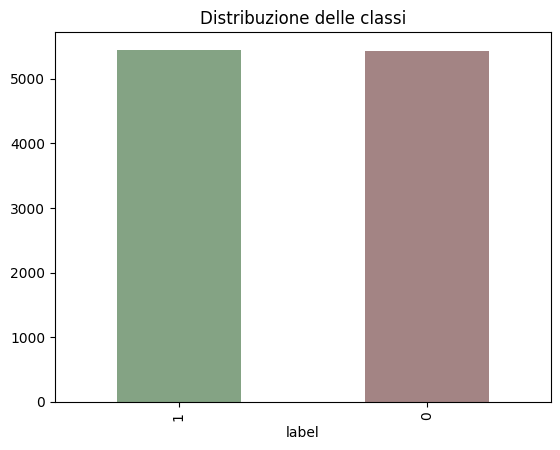

In [18]:
augmented_dataset['label'].value_counts().plot(kind='bar', color=[color1,color2])
plt.title('Distribuzione delle classi')
plt.show()

In [19]:
print("dati mancanti")
print(augmented_dataset.isna().sum())

dati mancanti
text     0
label    0
dtype: int64


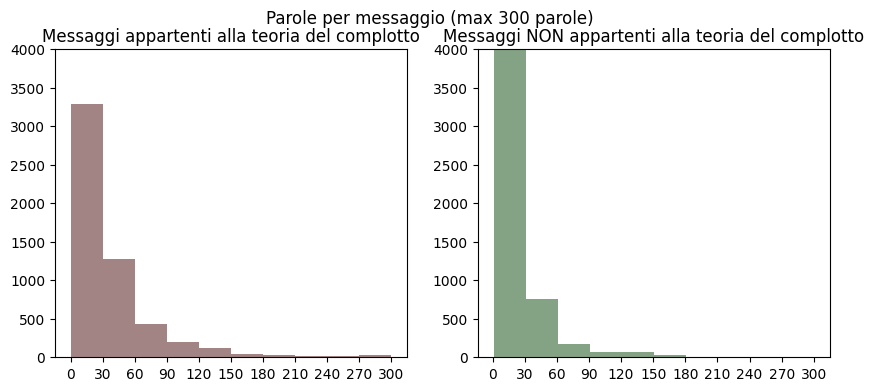

In [20]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
ax1.set_xticks([0,30,60,90,120,150,180,210,240,270,300])
ax1.set_ylim([0,4000])
ax2.set_xticks([0,30,60,90,120,150,180,210,240,270,300])
ax2.set_ylim([0,4000])
dataset_words=augmented_dataset[augmented_dataset['label']==1]['text'].str.split().map(lambda x: len(x) if len(x)<300 else 300)
ax1.hist(dataset_words,color=color2)
ax1.set_title('Messaggi appartenti alla teoria del complotto')
dataset_words=augmented_dataset[augmented_dataset['label']==0]['text'].str.split().map(lambda x: len(x) if len(x)<300 else 300)
ax2.hist(dataset_words,color=color1)
ax2.set_title('Messaggi NON appartenti alla teoria del complotto')
fig.suptitle('Parole per messaggio (max 300 parole)')
plt.show()

Dai dati rilevati e mostrati sopra, possiamo osservare come si sia mantenuta la relazione, seppur appiattita, del maggior numero di caratteri per i messaggi appartenti alla teoria del complotto, viene quindi integrata la colonna che include i caratteri del testo

In [21]:
augmented_dataset['char_count'] = augmented_dataset['text'].str.len()
augmented_dataset.head()

,text,label,char_count
0,⚡Se non ci fossero soldati non ci sarebbero guerre.,0,51
1,"21/08/21]( [PRE-PRINT] 📄__ ""Shedding of Infectious SARS-CoV-2 Despite Vaccination"" 🇮🇹 ""Diffusione del SARS-CoV-2 nonostante la vaccinazione""__ 📊 ""La variante Delta del SARS-CoV-2 può causare elevate cariche virali, è al trasmissibile e contiene mutazioni che conferiscono una fuga immunitaria parziale. [...] le indagini sull'epidemia suggeriscono che le persone vaccinate possono diffondere [la variante] Delta"" ⚠️ ""[...] questi risultati indicano che anche le **persone asintomatiche e comple vaccinate possono diffondere il virus infettivo**."" ⚠️ ""[...] questi dati indicano che gli individui **vaccinati e non vaccinati** infettati dalla variante Delta **possono trasmettere l'infezione**."" 📚 **",1,715
2,"PAURA E DELIRIO ALLA CNN: IL MINISTERO DELLA VERITA' La scorsa settimana Elon Musk ha dichiarato di volere che la ""libertà di parola"" sui social media sia tutelata ai sensi della Legge del Paese. I DEM sono spaventatissimi dalla scelta coraggiosa del magnate dello Spazio di acquistare Twitter così scontrandosi frontalmente, e senza paura, con BlackRock, Vanguard e State Street, cioè i tre fondi di inves che controllano il 95% delle multinazionali tra le prime 500 al Mondo. I DEM americani hanno risposto con la grande sorella Hillary e il grande fratello Obama, i quali twittando hanno ordinato di allestire opportuni apparati di censura, una comanda ovviamente presa dai loro camerieri della UE e della ridicola Amministrazione Biden. Si tratta di un disperato tentativo di nascondere le Verità che stanno emergendo sul Covid19 e i vaccini, i supposti morti 'senza correlazione', le elezioni americane e francesi colossalmente truccate, i ladrocini finanziari trilionari con i derivati, i sacrifici umani e soprattutto di bambini e tante altre rivelazioni usando un ""Ministero della Verità"" in perfetto stile Orwell 1984. Questa risposta DEM è assolu incostituzionale e non basta chiamare questi abomini 'Board per la Disinformazione' (in America) o 'Piattaforma per la Disinformazione' (in Unione Europea) per giustificare il tentativo di nascondere la Verità agli occhi della gente, tentando di non sembrare quello che sempre più palesemente si è: Tiranni Globali come quelli descritti in tutta la Letteratura distopica. Ricordo che Twitter aveva censurato la Verità sul laptop di Hunter Biden poco prima delle elezioni del 2020, e se ciò non fosse stato fatto e i media avessero fatto il loro lavoro, tutti sapremmo dei traffici di esseri umani ed energetici all'ombra di BURISMA, la compagnia del gas Ucraino nel cui board sedeva il figlio di Joe Biden dopo il colpo di stato del 2014, per il fine di realizzare in Ucraina quella base della piattaforma del Male oggi usata per alimentare la possibilità di una Terza Guerra Mondiale Nucleare. Le cose stanno precipitando per i DEM con la prospettiva di ricongiungerli ai loro DEMoni ispiratori. In questo senso è al simbolica l'uscita dell'analista politico della CNN David Zurawik di ieri, quando ha detto che è molto pericolosa l'acquisizione di Twitter da parte di Elon Musk, e che l'America deve guardare all'Europa per le risposte. In preda ad un sen di paura e delirio come quello del letterato iconico dei democratici americani, il drogato di adrenocromo Hunter Thompson nel suo famoso romanzo autobiografico ""Paura e Delirio al Las Vegas"", l'opinionista della CNN ha dichiarato: ""Hai bisogno di regolamentazione. Non puoi lasciare che questi ragazzi controllino la narrazione in questo paese o saremo diretti all'inferno. Noi ci siamo. Trump ha aperto le porte dell'inferno e ora ci stanno inseguendo"". Sono d'accordo con David Zurawik ma nel senso che le porte dell'Inferno sono effettivamente spalancate e pronte ad accogliere i meritevoli. Tutti gli esseri umani corrotti dal potere, dalla fama e dal denaro che sono stati strumenti del maligno, avranno il loro posto meritato. Nove, Nove, Nove. P.S. Godetevi il vide

In [22]:
#Effettuiamo lo shuffle per evitare problemi al classificatore
augmented_dataset = shuffle(augmented_dataset, random_state=42)
augmented_dataset.head()

,text,label,char_count
4899,"DA DIFFONDERE!! Statistiche ufficiali VAERS-CDC Stati Uniti: i seri COVID-19 sono 50 volte più mortali dei vaccini antigripali!! Altri che vaccini, sono seri assassini!! Negli Stati Uniti solo nei primi 14 mesi, 743.179 segnalazioni di avvenimenti negativi (una piccola parte dei reali)!!",1,290
7605,Come la piattaforma in questione sta affrontando il problema delle limitazioni alla libertà di espressione?,1,108
3813,"Poiché diversi individui hanno affermato che Berlusconi non si è opposto alla frode COVID nel corso dei due ultimi anni, qual partito proposevote che promuova la fine del cancro femminile, la fine della frode COVID, l'avversione alla invasione russa e una migliore condizione generale?",1,287
1803,Ma vediamo ... cosa risponde un noto astrofisico... alla domanda : si puo' creare una pressione gassosa senza un contenitore??.... Ovviamente se ci sarebbe un modo per creare una pressione senza contenitore la teoria della terra piatta con cupola.. non sarebbe piu' tanto attendibile... Ma vediamo cosa risponde l'astrofisico..,1,329
1576,Joe Biden dice ai cittadini della Pennsylvania di eleggere Josh Shapiro come senatore (si candida a governatore) e di eleggere John Fetterman come governatore (si candida per il Senato). Tutto normale.,0,201


Qui vengono scovate ed analizzate le emoticon, permettendoci di aggiungere le colonne che riguardano le emoticon presenti ed il loro numero

In [7]:
import re
def add_emoji(dataset):

    augmented_dataset = dataset.copy()
    augmented_dataset['emoji'] = ' '

    for i in tqdm(range(len(dataset)), desc= "Looking for emoji"):
        text = dataset.loc[i,'text']
        data = emoji.demojize(text, language='it')
        pattern = r":(\w+):"

        emoji_found = re.findall(pattern,data)
        emoji_found = ' '.join(emoji_found)
        augmented_dataset.at[i,'emoji'] = emoji_found

    return augmented_dataset

In [24]:
augmented_dataset = add_emoji(augmented_dataset)
augmented_dataset.head()

Looking for emoji:   0%|          | 0/10884 [00:00<?, ?it/s]

,text,label,char_count,emoji
4899,"DA DIFFONDERE!! Statistiche ufficiali VAERS-CDC Stati Uniti: i seri COVID-19 sono 50 volte più mortali dei vaccini antigripali!! Altri che vaccini, sono seri assassini!! Negli Stati Uniti solo nei primi 14 mesi, 743.179 segnalazioni di avvenimenti negativi (una piccola parte dei reali)!!",1,290,
7605,Come la piattaforma in questione sta affrontando il problema delle limitazioni alla libertà di espressione?,1,108,
3813,"Poiché diversi individui hanno affermato che Berlusconi non si è opposto alla frode COVID nel corso dei due ultimi anni, qual partito proposevote che promuova la fine del cancro femminile, la fine della frode COVID, l'avversione alla invasione russa e una migliore condizione generale?",1,287,
1803,Ma vediamo ... cosa risponde un noto astrofisico... alla domanda : si puo' creare una pressione gassosa senza un contenitore??.... Ovviamente se ci sarebbe un modo per creare una pressione senza contenitore la teoria della terra piatta con cupola.. non sarebbe piu' tanto attendibile... Ma vediamo cosa risponde l'astrofisico..,1,329,
1576,Joe Biden dice ai cittadini della Pennsylvania di eleggere Josh Shapiro come senatore (si candida a governatore) e di eleggere John Fetterman come governatore (si candida per il Senato). Tutto normale.,0,201,


Viene applicato lo stesso trattamento per gli hashtag

In [8]:
def add_hashtag(dataset):
    augmented_dataset = dataset.copy()
    augmented_dataset['hashtag'] = ' '
    data = []

    for i in tqdm(range(len(dataset)), desc= "Looking for hashtag"):
        text = dataset.loc[i,'text']
        dato = [k for k in text.split() if k.startswith("#")]
        data.append(dato)

    augmented_dataset['hashtag'] = data
    augmented_dataset['hashtag'] = augmented_dataset['hashtag'].apply(lambda x: " ".join(x).replace('#', ''))


    return augmented_dataset

In [26]:
augmented_dataset = add_hashtag(augmented_dataset)
augmented_dataset.head()

Looking for hashtag:   0%|          | 0/10884 [00:00<?, ?it/s]

,text,label,char_count,emoji,hashtag
4899,"DA DIFFONDERE!! Statistiche ufficiali VAERS-CDC Stati Uniti: i seri COVID-19 sono 50 volte più mortali dei vaccini antigripali!! Altri che vaccini, sono seri assassini!! Negli Stati Uniti solo nei primi 14 mesi, 743.179 segnalazioni di avvenimenti negativi (una piccola parte dei reali)!!",1,290,,
7605,Come la piattaforma in questione sta affrontando il problema delle limitazioni alla libertà di espressione?,1,108,,
3813,"Poiché diversi individui hanno affermato che Berlusconi non si è opposto alla frode COVID nel corso dei due ultimi anni, qual partito proposevote che promuova la fine del cancro femminile, la fine della frode COVID, l'avversione alla invasione russa e una migliore condizione generale?",1,287,,
1803,Ma vediamo ... cosa risponde un noto astrofisico... alla domanda : si puo' creare una pressione gassosa senza un contenitore??.... Ovviamente se ci sarebbe un modo per creare una pressione senza contenitore la teoria della terra piatta con cupola.. non sarebbe piu' tanto attendibile... Ma vediamo cosa risponde l'astrofisico..,1,329,,
1576,Joe Biden dice ai cittadini della Pennsylvania di eleggere Josh Shapiro come senatore (si candida a governatore) e di eleggere John Fetterman come governatore (si candida per il Senato). Tutto normale.,0,201,,


In [27]:
augmented_dataset.to_csv(f'{root}augmented_dataset_with_added_cols.csv', index=False)


Definizione pipeline

In [9]:
hyperparameters = {
    "#_classes" : 1,
    "epochs": 40,
    "learning_rate": 1e-6,
    "batch_size": 5,
    "dropout": 0.1,
    "stopwords": False,
    "h_dim": 768,
    "patience": 10,
    "min_delta": 0.01,
    "language_model": "bert-base-multilingual-cased",
    "extra_features": 65, #32 emoji + 32 hashtag + 1 char_count
}

In [29]:
#(x_train, x_test,char_count_train,char_count_test, hashtag_train, hashtag_test,emoji_train,emoji_test,y_train, y_test) = train_test_split(augmented_dataset['text'],augmented_dataset['char_count'], augmented_dataset['hashtag'],augmented_dataset['emoji'] ,augmented_dataset['label'], test_size=0.2, random_state=42)

#(x_train, x_val,char_count_train,char_count_val, hashtag_train, hashtag_val, emoji_train, emoji_val, y_train, y_val) = train_test_split( x_train,char_count_train,hashtag_train,emoji_train, y_train, test_size=0.1, random_state=42)

In [30]:
(x_train, x_test,char_count_train,char_count_test, hashtag_train, hashtag_test,emoji_train,emoji_test,y_train, y_test) = train_test_split(augmented_dataset['text'],augmented_dataset['char_count'], augmented_dataset['hashtag'],augmented_dataset['emoji'] ,augmented_dataset['label'], test_size=0.1, random_state=42)


In [10]:
nltk.download('punkt')
nltk.download('stopwords')

class Dataset(torch.utils.data.Dataset):

    def __init__(self, x, char_count, emoji, hashtag, y, stopwords):


        tokens_litt = [nltk.word_tokenize(text, language='italian') for text in list(x)]

        text_clean = []

        for sentence in tqdm(tokens_litt, desc='Tokenizing text ... '):
            text_clean.append(' '.join([w for w in sentence if not w.lower() in nltk.corpus.stopwords.words("italian")]))


        self.texts = [text for text in text_clean]
        self.emoji = [e for e in emoji]
        self.hashtag = [h for h in hashtag]
        self.labels = [torch.tensor(label) for label in y]
        self.char_count = [torch.tensor(char_count) for char_count in char_count]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def get_batch_char_count(self, idx):
        # Fetch a batch of inputs
        return self.char_count[idx]

    def get_batch_emoji(self, idx):
        # Fetch a batch of inputs
        return self.emoji[idx]

    def get_batch_hashtag(self, idx):
        # Fetch a batch of inputs
        return self.hashtag[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_labels = self.get_batch_labels(idx)
        batch_char_count = self.get_batch_char_count(idx)
        batch_emoji = self.get_batch_emoji(idx)
        batch_hashtag = self.get_batch_hashtag(idx)

        return batch_texts, batch_labels, batch_char_count, batch_emoji, batch_hashtag

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
#train_dataset = Dataset(x_train, char_count_train,emoji_train,hashtag_train, y_train, hyperparameters["stopwords"])
#val_dataset = Dataset(x_val,char_count_val,emoji_val,hashtag_val, y_val, hyperparameters["stopwords"])
#test_dataset = Dataset(x_test, char_count_test,emoji_test,hashtag_test, y_test, hyperparameters["stopwords"])

In [33]:
train_dataset = Dataset(x_train, char_count_train,emoji_train,hashtag_train, y_train, hyperparameters["stopwords"])
test_dataset = Dataset(x_test, char_count_test,emoji_test,hashtag_test, y_test, hyperparameters["stopwords"])

Tokenizing text ... :   0%|          | 0/9795 [00:00<?, ?it/s]

Tokenizing text ... :   0%|          | 0/1089 [00:00<?, ?it/s]

In [12]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):

        self.patience = patience
        self.min_delta = min_delta              # valore minimo di decrescita della loss di validazione all'epoca corrente
                                                # per asserire che c'è un miglioramenti della loss
        self.counter = 0                        # contatore delle epoche di pazienza
        self.early_stop = False                 # flag di early stop
        self.min_validation_loss = torch.inf    # valore corrente ottimo della loss di validazione

    def __call__(self, validation_loss):
        # chiamata in forma funzionale dell'oggetto di classe EarlySopping
        if (validation_loss + self.min_delta) >= self.min_validation_loss:  # la loss di validazione non decresce
            self.counter += 1                                               # incrementiamo il contatore delle epoche di pazienza
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stop!")
        else:                                                               # c'è un miglioramento della loss:
            self.min_validation_loss = validation_loss                      # consideriamo la loss corrente
                                                                            # come nuova loss ottimale
            self.counter = 0                                                # e azzeriamo il contatore di pazienza

In [11]:
class ClassifierDeep(nn.Module):

    def __init__(self, labels, hdim, dropout, model_name,extra_features = hyperparameters['extra_features']):
        super(ClassifierDeep, self).__init__()
        config = AutoConfig.from_pretrained(model_name)
        self.lm_model = AutoModel.from_pretrained(model_name, config=config)
        self.classifier = nn.Sequential(
            nn.Linear(hdim + extra_features, 512),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
            )

    def forward(self, input_id_text, attention_mask, char_count,emoji_text, hashtag):
        output = self.lm_model(input_id_text, attention_mask).last_hidden_state
        output = output[:,0,:]
        output = torch.cat((output, char_count.unsqueeze(-1), emoji_text, hashtag), dim=1)  # Concatena il conteggio dei caratteri
        return self.classifier(output)

In [18]:
def train_loop(model, dataloader, tokenizer, loss, optimizer, device):
    model.train()

    epoch_acc = 0
    epoch_loss = 0

    for batch_texts, batch_labels, batch_char_count, emoji, hashtag in tqdm(dataloader, desc='training set'):

        optimizer.zero_grad()
        tokens = tokenizer(list(batch_texts), add_special_tokens=True,
                            return_tensors='pt', padding='max_length',
                            max_length = 400, truncation=True)
        tokens_emoji = tokenizer(list(emoji), add_special_tokens=True,
                            return_tensors='pt', padding='max_length',
                            max_length = 32, truncation=True)
        tokens_hashtag = tokenizer(list(hashtag), add_special_tokens=True,
                            return_tensors='pt', padding='max_length',
                            max_length = 32, truncation=True)

        input_id_texts = tokens['input_ids'].squeeze(1).to(device)
        mask_texts = tokens['attention_mask'].squeeze(1).to(device)

        input_id_emoji = tokens_emoji['input_ids'].squeeze(1).to(device)
        mask_emoji = tokens_emoji['attention_mask'].squeeze(1).to(device)

        input_id_hashtag = tokens_hashtag['input_ids'].squeeze(1).to(device)
        mask_hashtag = tokens_hashtag['attention_mask'].squeeze(1).to(device)


        batch_char_count = batch_char_count.to(device)
        batch_labels = batch_labels.to(device)
        batch_char_count = batch_char_count.to(device)



        output = model(input_id_texts, mask_texts,batch_char_count, input_id_emoji, input_id_hashtag)

        # la loss è una CrossEntropyLoss, al suo interno ha la logsoftmax + negative log likelihood loss
        batch_loss = loss(output, batch_labels.unsqueeze(-1).float())
        batch_loss.backward()
        optimizer.step()

        epoch_loss += batch_loss.item()

        # per calcolare l'accuracy devo generare le predizioni applicando manualmente la logsoftmax
        #softmax = nn.LogSoftmax(dim=1)
        #epoch_acc += (softmax(output).argmax(dim=1) == batch_labels).sum().item()
        epoch_acc += (output.squeeze().round() == batch_labels).float().mean()
        batch_labels = batch_labels.detach().cpu()
        input_id_texts = input_id_texts.detach().cpu()
        mask_texts = mask_texts.detach().cpu()
        output = output.detach().cpu()
        batch_char_count = batch_char_count.detach().cpu()


    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)

In [14]:
def test_loop(model, dataloader, tokenizer, loss, device, best_acc, best_weights):
    model.eval()

    epoch_acc = 0
    epoch_loss = 0

    with torch.no_grad():

        for batch_texts, batch_labels, batch_char_count, emoji, hashtag in tqdm(dataloader, desc='dev set'):

            tokens = tokenizer(list(batch_texts), add_special_tokens=True,
                               return_tensors='pt', padding='max_length',
                               max_length = 512, truncation=True)

            tokens_emoji = tokenizer(list(emoji), add_special_tokens=True,
                            return_tensors='pt', padding='max_length',
                            max_length = 32, truncation=True)
            tokens_hashtag = tokenizer(list(hashtag), add_special_tokens=True,
                                return_tensors='pt', padding='max_length',
                                max_length = 32, truncation=True)

            input_id_texts = tokens['input_ids'].squeeze(1).to(device)
            mask_texts = tokens['attention_mask'].squeeze(1).to(device)

            input_id_emoji = tokens_emoji['input_ids'].squeeze(1).to(device)
            mask_emoji = tokens_emoji['attention_mask'].squeeze(1).to(device)

            input_id_hashtag = tokens_hashtag['input_ids'].squeeze(1).to(device)
            mask_hashtag = tokens_hashtag['attention_mask'].squeeze(1).to(device)

            batch_labels = batch_labels.to(device)
            batch_char_count = batch_char_count.to(device)


            output = model(input_id_texts, mask_texts,batch_char_count,input_id_emoji, input_id_hashtag)

            batch_loss = loss(output, batch_labels.unsqueeze(-1).float())
            epoch_loss += batch_loss.item()

            #softmax = nn.LogSoftmax(dim=1)
            #epoch_acc += (softmax(output).argmax(dim=1) == batch_labels).sum().item()
            epoch_acc += (output.squeeze().round() == batch_labels).float().mean()


            batch_labels = batch_labels.detach().cpu()
            input_id_texts = input_id_texts.detach().cpu()
            mask_texts = mask_texts.detach().cpu()
            output = output.detach().cpu()
            batch_char_count = batch_char_count.detach().cpu()
        acc = float(epoch_acc/len(dataloader))
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())


    return epoch_loss/len(dataloader), epoch_acc/len(dataloader), best_acc, best_weights

In [15]:
def train_test(model, epochs, optimizer, device, train_data, test_data,
               batch_size, language_model, train_loss_fn, test_loss_fn=None,
               early_stopping=None, val_data=None, scheduler=None):

  train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  #val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
  test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

    # check sulle funzioni di loss
  if test_loss_fn == None:
    test_loss_fn = train_loss_fn

    # liste dei valori di loss e accuracy epoca per epoca per il plot
  train_loss = []
  validation_loss = []
  test_loss = []

  train_acc = []
  validation_acc = []
  test_acc = []
  best_acc = - np.inf
  best_weights = None
  tokenizer = AutoTokenizer.from_pretrained(language_model)

    # Ciclo di addestramento con early stopping
  for epoch in tqdm(range(1,epochs+1)):
    epoch_train_loss, epoch_train_acc = train_loop(model, train_dataloader, tokenizer, train_loss_fn, optimizer, device)
    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_acc/len(train_data))

        # validation se è presente la callback di early stopping
  #        if early_stopping != None:
  #              epoch_validate_loss, epoch_validate_acc = test_loop(model,
  #                              val_dataloader, tokenizer, test_loss_fn, device)
  #              validation_loss.append(epoch_validate_loss)
  #              validation_acc.append(epoch_validate_acc/len(val_data))

        # test
    epoch_test_loss, epoch_test_acc, best_acc, best_weights = test_loop(model, test_dataloader, tokenizer, test_loss_fn, device, best_acc, best_weights)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc/len(test_data))

    val_loss_str = f'Validation loss: {epoch_validate_loss:6.4f} ' if early_stopping != None else ' '
    val_acc_str = f'Validation accuracy: {(epoch_validate_acc):6.4f} ' if early_stopping != None else ' '
    print(f"\nTrain loss: {epoch_train_loss:6.4f} {val_loss_str}Test loss: {epoch_test_loss:6.4f}")
    print(f"Train accuracy: {(epoch_train_acc):6.4f} {val_acc_str}Test accuracy: {(epoch_test_acc):6.4f}")

        # early stopping
    #        if early_stopping != None:
    #            early_stopping(epoch_validate_loss)
    #            if early_stopping.early_stop:
    #                break

  return train_loss, validation_loss, test_loss, train_acc, validation_acc, test_acc, best_acc, best_weights

In [16]:
# Acquisiamo il device su cui effettueremo il training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

model = ClassifierDeep(hyperparameters["#_classes"],
                    hyperparameters["h_dim"],
                    hyperparameters["dropout"],
                    hyperparameters["language_model"]).to(device)
print(model)

# Calcoliamo il numero totale dei parametri del modello
total_params = sum(p.numel() for p in model.parameters())
print(f"Numbero totale dei parametri: {total_params}")
#La funzione di loss va modificata in base al parametro #_classes
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=hyperparameters["learning_rate"])

# Creiamo la callback di early stopping da passare al nostro metodo di addestramento
#early_stopping = EarlyStopping(patience=hyperparameters['patience'],
#                               min_delta=hyperparameters['min_delta'])

Using cuda device
ClassifierDeep(
  (lm_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), ep

In [40]:
train_loss, validation_loss,test_loss, train_acc, validation_acc, test_acc, best_acc, best_weights = train_test(
                                                model,
                                                hyperparameters['epochs'],
                                                optimizer,
                                                device,
                                                train_dataset,
                                                test_dataset,
                                                hyperparameters['batch_size'],
                                                hyperparameters['language_model'],
                                                criterion,
                                                criterion,
                                               )
with open("best_weight.pkl", 'wb') as f:
  pickle.dump(best_weights, f)



  0%|          | 0/40 [00:00<?, ?it/s]

training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 6.4306  Test loss: 6.8527
Train accuracy: 0.5497  Test accuracy: 0.6638


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 6.2700  Test loss: 6.8595
Train accuracy: 0.6769  Test accuracy: 0.7062


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 5.8859  Test loss: 6.8096
Train accuracy: 0.7245  Test accuracy: 0.7261


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 5.7026  Test loss: 6.2667
Train accuracy: 0.7500  Test accuracy: 0.7255


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 5.5708  Test loss: 6.0284
Train accuracy: 0.7787  Test accuracy: 0.7493


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 5.1570  Test loss: 3.5435
Train accuracy: 0.7925  Test accuracy: 0.7732


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 4.6988  Test loss: 5.4540
Train accuracy: 0.8114  Test accuracy: 0.7606


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 4.8202  Test loss: 5.3267
Train accuracy: 0.8296  Test accuracy: 0.7771


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 4.9130  Test loss: 5.3352
Train accuracy: 0.8381  Test accuracy: 0.7780


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 5.0631  Test loss: 5.2628
Train accuracy: 0.8465  Test accuracy: 0.7862


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 5.1607  Test loss: 5.2604
Train accuracy: 0.8565  Test accuracy: 0.7826


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 5.0792  Test loss: 4.2228
Train accuracy: 0.8662  Test accuracy: 0.8055


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 4.9258  Test loss: 4.1321
Train accuracy: 0.8702  Test accuracy: 0.7954


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 4.9215  Test loss: 4.2247
Train accuracy: 0.8754  Test accuracy: 0.7899


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 4.8565  Test loss: 4.2478
Train accuracy: 0.8785  Test accuracy: 0.8037


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 4.5922  Test loss: 4.3995
Train accuracy: 0.8835  Test accuracy: 0.8018


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 4.7487  Test loss: 4.2081
Train accuracy: 0.8877  Test accuracy: 0.7982


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 4.3651  Test loss: 4.3744
Train accuracy: 0.8961  Test accuracy: 0.8073


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 4.4562  Test loss: 4.2981
Train accuracy: 0.8944  Test accuracy: 0.8000


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 4.6375  Test loss: 4.1218
Train accuracy: 0.8965  Test accuracy: 0.8193


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 4.3852  Test loss: 4.0651
Train accuracy: 0.9017  Test accuracy: 0.8110


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 4.6119  Test loss: 4.1625
Train accuracy: 0.9019  Test accuracy: 0.8055


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 4.5791  Test loss: 4.2404
Train accuracy: 0.9042  Test accuracy: 0.8138


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 4.6143  Test loss: 4.3417
Train accuracy: 0.9050  Test accuracy: 0.8055


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 4.4624  Test loss: 4.3048
Train accuracy: 0.9062  Test accuracy: 0.8119


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 4.6619  Test loss: 4.2585
Train accuracy: 0.9049  Test accuracy: 0.8110


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 4.7132  Test loss: 4.3607
Train accuracy: 0.9070  Test accuracy: 0.8055


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 4.5692  Test loss: 4.2764
Train accuracy: 0.9050  Test accuracy: 0.8092


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 4.5779  Test loss: 4.2839
Train accuracy: 0.9097  Test accuracy: 0.8083


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 4.5129  Test loss: 4.2949
Train accuracy: 0.9073  Test accuracy: 0.8193


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 4.4187  Test loss: 4.3005
Train accuracy: 0.9128  Test accuracy: 0.8165


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 4.4071  Test loss: 4.2546
Train accuracy: 0.9116  Test accuracy: 0.8174


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 4.4882  Test loss: 4.2791
Train accuracy: 0.9130  Test accuracy: 0.8073


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 4.4304  Test loss: 4.2441
Train accuracy: 0.9129  Test accuracy: 0.8211


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 4.4475  Test loss: 4.2185
Train accuracy: 0.9129  Test accuracy: 0.8239


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 4.5861  Test loss: 4.3939
Train accuracy: 0.9107  Test accuracy: 0.8128


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 4.6460  Test loss: 4.3818
Train accuracy: 0.9136  Test accuracy: 0.8257


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 4.6256  Test loss: 4.3443
Train accuracy: 0.9145  Test accuracy: 0.8220


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 4.6027  Test loss: 4.3735
Train accuracy: 0.9131  Test accuracy: 0.8202


training set:   0%|          | 0/1959 [00:00<?, ?it/s]

dev set:   0%|          | 0/218 [00:00<?, ?it/s]


Train loss: 4.3826  Test loss: 4.3733
Train accuracy: 0.9191  Test accuracy: 0.8202


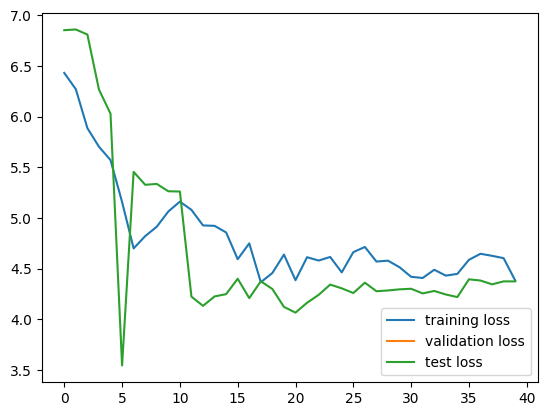

In [41]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.plot(test_loss, label='test loss')
plt.legend(loc='lower right')
plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

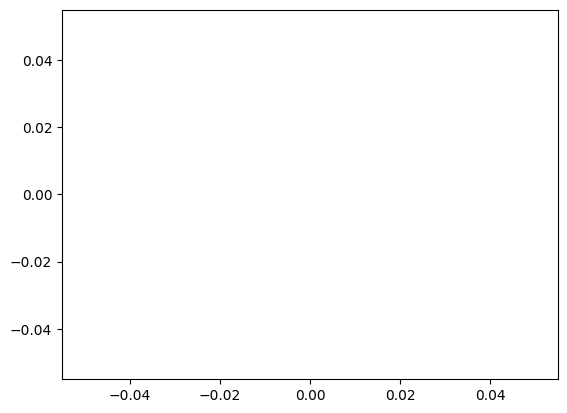

In [42]:
train_acc = [ np.array(x.cpu().float()) for x in train_acc ]
validation_acc = [ np.array(x.cpu().float()) for x in validation_acc ]
test_acc = [ np.array(x.cpu().float()) for x in test_acc ]


plt.plot(train_acc, label='training accuracy')
plt.plot(validation_acc, label='validation accuracy')
plt.plot(test_acc, label='test accuracy')
plt.legend(loc='lower right')
plt.ylim(0,2)
plt.show()

Per completezza viene testato anche il dataset originale con le sole colonne aggiunte

In [19]:
dataset = pd.read_csv(f'{root}subtaskA_train.csv',  header=0, names=['id', 'text', 'label'])
dataset['text'] = dataset['text'].apply(lambda x: x.replace('\r', ' ').replace('\n', ' '))
dataset['char_count'] = dataset['text'].str.len()
dataset = add_emoji(dataset)
dataset = add_hashtag(dataset)
dataset.drop(columns=['id'], inplace=True)
dataset = shuffle(dataset, random_state=42)

(x_train_original_dataset, x_test_original_dataset,char_count_train_original_dataset,char_count_test_original_dataset, hashtag_train_original_dataset, hashtag_test_original_dataset,emoji_train_original_dataset,emoji_test_original_dataset,y_train_original_dataset, y_test_original_dataset) = train_test_split(dataset['text'],dataset['char_count'], dataset['hashtag'],dataset['emoji'] ,dataset['label'], test_size=0.2, random_state=42)

#(x_train_original_dataset, x_val_original_dataset,char_count_train_original_dataset,char_count_val_original_dataset, hashtag_train_original_dataset, hashtag_val_original_dataset, emoji_train_original_dataset, emoji_val_original_dataset, y_train_original_dataset, y_val_original_dataset) = train_test_split( x_train_original_dataset,char_count_train_original_dataset,hashtag_train_original_dataset,emoji_train_original_dataset, y_train_original_dataset, test_size=0.1, random_state=42)

train_dataset_original_dataset = Dataset(x_train_original_dataset, char_count_train_original_dataset,emoji_train_original_dataset,hashtag_train_original_dataset, y_train_original_dataset, hyperparameters["stopwords"])
#val_dataset_original_dataset = Dataset(x_val_original_dataset,char_count_val_original_dataset,emoji_val_original_dataset,hashtag_val_original_dataset, y_val_original_dataset, hyperparameters["stopwords"])
test_dataset_original_dataset = Dataset(x_test_original_dataset, char_count_test_original_dataset,emoji_test_original_dataset,hashtag_test_original_dataset, y_test_original_dataset, hyperparameters["stopwords"])


model = ClassifierDeep(hyperparameters["#_classes"],
                    hyperparameters["h_dim"],
                    hyperparameters["dropout"],
                    hyperparameters["language_model"]).to(device)

#La funzione di loss va modificata in base al parametro #_classes
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=hyperparameters["learning_rate"])

# Creiamo la callback di early stopping da passare al nostro metodo di addestramento
#early_stopping = EarlyStopping(patience=hyperparameters['patience'],
#                               min_delta=hyperparameters['min_delta'])


train_loss_original_dataset, validation_loss_original_dataset,test_loss_original_dataset, train_acc_original_dataset, validation_acc_original_dataset, test_acc_original_dataset, best_acc, best_weights = train_test(
                                                model,
                                                hyperparameters['epochs'],
                                                optimizer,
                                                device,
                                                train_dataset_original_dataset,
                                                test_dataset_original_dataset,
                                                hyperparameters['batch_size'],
                                                hyperparameters['language_model'],
                                                criterion,
                                                criterion,
                                                None,
                                                None)
with open("best_weight_original.pkl", 'wb') as f:
  pickle.dump(best_weights, f)


Looking for emoji:   0%|          | 0/1842 [00:00<?, ?it/s]

Looking for hashtag:   0%|          | 0/1842 [00:00<?, ?it/s]

Tokenizing text ... :   0%|          | 0/1473 [00:00<?, ?it/s]

Tokenizing text ... :   0%|          | 0/369 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 14.0468  Test loss: 11.8309
Train accuracy: 0.5040  Test accuracy: 0.6284


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 13.1728  Test loss: 9.8908
Train accuracy: 0.6090  Test accuracy: 0.6311


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 13.4991  Test loss: 9.0049
Train accuracy: 0.6307  Test accuracy: 0.6365


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 11.9542  Test loss: 8.7160
Train accuracy: 0.6701  Test accuracy: 0.6743


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 11.8202  Test loss: 13.4705
Train accuracy: 0.6823  Test accuracy: 0.6635


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 13.4193  Test loss: 13.1017
Train accuracy: 0.6850  Test accuracy: 0.6824


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 11.9445  Test loss: 13.0995
Train accuracy: 0.7241  Test accuracy: 0.6662


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 13.2284  Test loss: 15.9270
Train accuracy: 0.7290  Test accuracy: 0.6662


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 13.2465  Test loss: 13.0623
Train accuracy: 0.7586  Test accuracy: 0.7014


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 13.3516  Test loss: 13.0510
Train accuracy: 0.7779  Test accuracy: 0.6878


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 12.7061  Test loss: 13.0931
Train accuracy: 0.7860  Test accuracy: 0.6993


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 12.3125  Test loss: 13.1522
Train accuracy: 0.8090  Test accuracy: 0.6993


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 12.7348  Test loss: 13.1785
Train accuracy: 0.8084  Test accuracy: 0.6824


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 12.9834  Test loss: 13.2840
Train accuracy: 0.8138  Test accuracy: 0.7074


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 12.8104  Test loss: 13.2259
Train accuracy: 0.8212  Test accuracy: 0.6939


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 11.4862  Test loss: 13.4006
Train accuracy: 0.8332  Test accuracy: 0.6885


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 12.7452  Test loss: 13.2688
Train accuracy: 0.8267  Test accuracy: 0.6959


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 13.1275  Test loss: 13.5074
Train accuracy: 0.8280  Test accuracy: 0.6878


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 12.1285  Test loss: 13.4872
Train accuracy: 0.8436  Test accuracy: 0.6905


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 12.1340  Test loss: 13.6562
Train accuracy: 0.8359  Test accuracy: 0.6878


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 12.3796  Test loss: 13.6657
Train accuracy: 0.8366  Test accuracy: 0.6750


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 12.6433  Test loss: 13.7200
Train accuracy: 0.8425  Test accuracy: 0.6824


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 12.4169  Test loss: 13.7074
Train accuracy: 0.8481  Test accuracy: 0.6878


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 12.0112  Test loss: 13.5567
Train accuracy: 0.8536  Test accuracy: 0.7095


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 12.2031  Test loss: 13.7496
Train accuracy: 0.8502  Test accuracy: 0.6932


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 12.2216  Test loss: 13.7341
Train accuracy: 0.8468  Test accuracy: 0.6905


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 12.4084  Test loss: 13.6405
Train accuracy: 0.8504  Test accuracy: 0.6858


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 12.1897  Test loss: 13.8193
Train accuracy: 0.8522  Test accuracy: 0.6912


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 11.9112  Test loss: 13.8059
Train accuracy: 0.8549  Test accuracy: 0.6878


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 12.7792  Test loss: 14.0992
Train accuracy: 0.8441  Test accuracy: 0.6797


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 11.6986  Test loss: 14.0211
Train accuracy: 0.8612  Test accuracy: 0.6912


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 10.9048  Test loss: 13.8208
Train accuracy: 0.8631  Test accuracy: 0.6878


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 10.6591  Test loss: 14.1013
Train accuracy: 0.8624  Test accuracy: 0.6885


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 12.0547  Test loss: 14.2124
Train accuracy: 0.8590  Test accuracy: 0.6885


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 11.3597  Test loss: 14.1939
Train accuracy: 0.8678  Test accuracy: 0.6878


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 11.3678  Test loss: 14.2114
Train accuracy: 0.8617  Test accuracy: 0.6932


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 11.2174  Test loss: 14.3034
Train accuracy: 0.8651  Test accuracy: 0.6851


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 11.7820  Test loss: 14.2238
Train accuracy: 0.8574  Test accuracy: 0.6797


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 11.1650  Test loss: 14.2453
Train accuracy: 0.8610  Test accuracy: 0.6689


training set:   0%|          | 0/295 [00:00<?, ?it/s]

dev set:   0%|          | 0/74 [00:00<?, ?it/s]


Train loss: 12.1946  Test loss: 14.1304
Train accuracy: 0.8583  Test accuracy: 0.6689


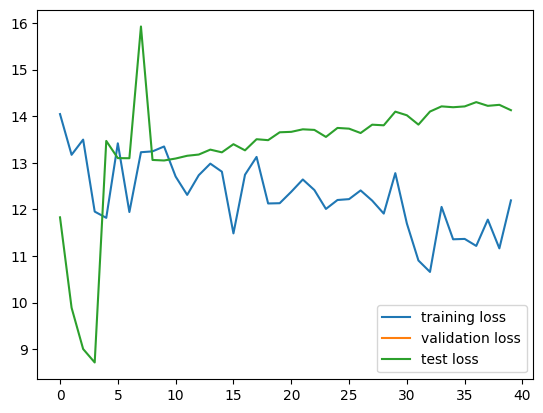

In [20]:
plt.plot(train_loss_original_dataset, label='training loss')
plt.plot(validation_loss_original_dataset, label='validation loss')
plt.plot(test_loss_original_dataset, label='test loss')
plt.legend(loc='lower right')
plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

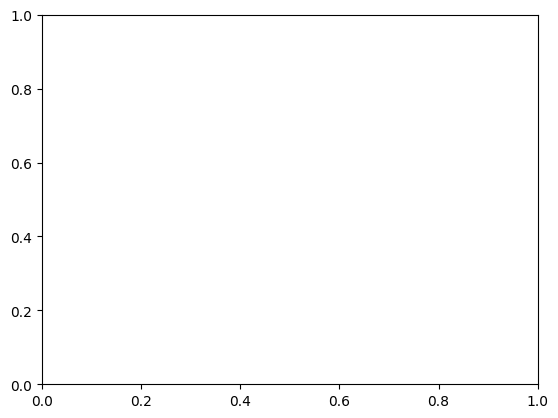

In [21]:
train_acc_original_dataset = [ np.array(x.cpu().float()) for x in train_acc_original_dataset ]
validation_acc_original_dataset = [ np.array(x.cpu().float()) for x in validation_acc_original_dataset ]
test_acc_original_dataset = [ np.array(x.cpu().float()) for x in test_acc_original_dataset ]

plt.plot(train_acc_original_dataset, label='training accuracy')
plt.plot(validation_acc_original_dataset, label='validation accuracy')
plt.plot(test_acc_original_dataset, label='test accuracy')
plt.legend(loc='lower right')
plt.ylim(0,2)
plt.show()